In [91]:
import svgwrite
import numpy as np
import random
import pickle
import codecs
import collections
import os
import math
import json
from six.moves import xrange
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from numpy import linalg as LA
import numpy as np
from tqdm.auto import tqdm, trange
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
# libraries required for visualisation of SVG:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# Data

## Fonctions to display svg from a single or multiple arrays

In [6]:
# helper function for draw_strokes
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in xrange(len(data)):
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)
    
    return (min_x, max_x, min_y, max_y)

fact=4 #factor at 2 for ESN

# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=fact, svg_filename = 'sample.svg',ini=20): 
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    p1 = p
    command = "m"
    delta_x = 0
    delta_y = 0
    it=0
    while it < len(data):

        for i in xrange(0,ini):
            if (lift_pen == 1):
                command = "m"
            elif (command != "l"):
                command = "l"
            else:
                command = ""
            x = float(data[it,0])/factor
            y = float(data[it,1])/factor
            lift_pen = data[it, 2]
            p += command+str(x)+","+str(y)+" "
            p1 += command+str(x)+","+str(y)+" "
            the_color1 = "red"
            stroke_width1 = 2
            
            it+=1
        delta_x = 0
        delta_y = 0
        for i in xrange(ini,len(data)):
            #print(data[it+i,:].tolist()==[0,0,0])
            #print(len(data),it,i,data[it,:])
            if data[it,:].tolist()==[0,0,0]:
                #print("pop")
                it+=1
                break
            if (lift_pen == 1):
                command = "m"
            elif (command != "l"):
                command = "l"
            else:
                command = ""
            x = float(data[it,0])/factor
            y = float(data[it,1])/factor
            delta_x += x
            delta_y += y 
            lift_pen = data[it, 2]
            p1 += command+str(x)+","+str(y)+" "
            it+=1
            the_color2 = "black"
            stroke_width2 = 1
        p += "m"+str(delta_x)+","+str(delta_y)+" "
    dwg.add(dwg.path(p).stroke(the_color1,stroke_width1).fill("none"))
    dwg.add(dwg.path(p1).stroke(the_color2,stroke_width2).fill("none"))
    #dwg.save()
    display(SVG(dwg.tostring()))
    
# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space_fact=2, grid_space_x_fact=3,factor=fact):
    # get the right "grid_space" to plot in grid
    def grid_space(s_list, factor):
        dims_max=[0,0]
        for sample in s_list:
            min_x, max_x, min_y, max_y = get_bounds(sample[0],factor)
            dims = (50 + max_x - min_x, 50 + max_y - min_y)
            dims_max=[max(dims[0],dims_max[0]), max(dims[1],dims_max[1])]
        return dims_max
    
    grid_space_x,grid_space=grid_space(s_list,factor)
    grid_space_x = grid_space_x*grid_space_x_fact
    grid_space = grid_space*grid_space_fact
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
        result.append([0,0,0])
    return np.array(result)

## Loading the data

70000
2500
2500


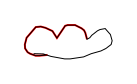

In [88]:
data_dir = 'cloud.npz'

load_data = np.load(data_dir, encoding='latin1', allow_pickle=True) #specific to python3
train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']

print (len(train_set))
print (len(valid_set))
print (len(test_set))

draw_strokes(random.choice(test_set))

# Linear regression

## Creating models

This section deals with creating a dictionary of multiple models to see the effects of the following hyper-parameters:
* the size of the sliding window
* the coefficient of the linear regression
* whether the distance from the start of the drawing is used by the linear regression

In [28]:
Size_wind_reg = [5,10,15,20,30] # size of the window for the linear regression
Coef_reg = [10**i for i in (range(-5,16,5))] # alpha coefficient of ridge regression 
Initial_point = [True, False] # whether the distance from the start of the drawing is used by the linear regression
data = train_set[0:70000] 

In [58]:
# The filling of the matrix X and Y for linear regression is filled using python list rather than numpy array for greater
# time efficacy.

Dict_W={} #Storage of the diffeent weight matrices for the different hyperparameters


# Implementation of ridge regression for the different hyper-parameters
counter=0
for s_win in Size_wind_reg:
    for ini in Initial_point:
        counter+=1
        print(counter)
        s_win_total =s_win + int(ini)

        X=[]
        Y=[]

        for sample in tqdm(data):
            i=0
            abs_x = sample[s_win,0].cumsum()[0]
            abs_y = sample[s_win,0].cumsum()[0]
            while i+s_win_total+1 < len(sample):
                
                x = sample[i:i+s_win,0:2].ravel().tolist()
                y = sample[i+s_win+1,0:2].ravel().tolist()
                
                abs_x += sample[i+s_win,0]
                abs_y += sample[i+s_win,1]
                if ini == True:
                    x.append(abs_x)
                    x.append(abs_y)
                i+=1                
                
                X.append(x)
                Y.append(y)
                
        X = np.array(X)
        Y = np.array(Y)
        
        for alpha in Coef_reg:
            inv=np.linalg.inv(np.dot(X.T,X)+alpha*np.identity(s_win_total*2))
            W=np.dot(np.dot(inv,X.T),Y)
            Dict_W[str(s_win)+str(ini)+str(alpha)]=W

1



2



3



4



5



6



7



8



9



10


## Loading a model

3 models are stored:
* "linear_reg1000"
* "linear_reg10000"
* "linear_reg70000"

the last number indicate the number of data used to create Dict_W with the hyperparameters indicated in the previous subsection.

In [9]:
with open('linear_reg10000', 'rb') as fp:
    Dict_W = pickle.load(fp)

## Testing the model

In [10]:
data_test = test_set

### Testing function

In [11]:
def test_model(s_win,ini,alpha,l_input,test_i,lenght=300): #l_input need to be superior to s_win
    W=Dict_W[str(s_win)+str(ini)+str(alpha)]
    #print(W)
    #print("s_win:"+str(s_win),"ini"+str(ini),"alpha"+str(alpha),"l_input"+str(l_input))
    
    # data flatten
    drawing_input = data_test[test_i][l_input-s_win:l_input,0:2].ravel()  #l_input to take into account
    ini_point=[data_test[test_i][0,0:2].ravel()]

    # storage of data as array for ploting
    draw = data_test[test_i][0:l_input,0:2] #l_input to take into account
    for i in range (lenght):
        if ini == True:
            #print(drawing_input)
            #print(data_test[test_i][0,0:2].ravel() ),
            drawing_input = np.hstack((drawing_input,data_test[test_i][0,0:2].ravel()))
        #print(drawing_input)    
        draw = np.vstack((draw, np.dot(drawing_input,W)))  #need to check if x and y are not reversed
        drawing_input = draw[-s_win:,0:2].ravel()


    draw=np.hstack((draw, np.zeros((draw.shape[0],1)))) # I do not take into account the different strokes
    #print(draw,draw.shape[0],np.zeros((draw.shape[0],0)))
    #draw_strokes(draw,ini=l_input)
    #print("true")
    #draw_strokes(data_test[test_i])
    return draw, np.linalg.norm(W[:,0]),np.linalg.norm(W[:,1])

### EigenValues calculation function

In [85]:
# Function to calculate the eigenvalues used to gauge the stability of the linear regression

def matrix_A(s_win,ini,alpha):
    W = Dict_W[str(s_win)+str(ini)+str(alpha)]
    size_wind_total = s_win + int(ini)
    
    A1 = np.zeros((size_wind_total,size_wind_total))
    A1[-1,:] = W[:,0].reshape(-1,2)[:,1]
    B1 = np.zeros((size_wind_total,size_wind_total))
    B1[-1,:] = W[:,1].reshape(-1,2)[:,0]
    
    rng = np.arange(size_wind_total-1)
    
    A0 = np.zeros((size_wind_total, size_wind_total), int)
    A0[rng, rng+1] = 1
    A0[-1,:] = W[:,0].reshape(-1,2)[:,0]
    
    B0 = np.zeros((size_wind_total, size_wind_total), int)
    B0[rng, rng+1] = 1
    B0[-1,:] = W[:,0].reshape(-1,2)[:,0]
    
    if ini == True:
        A1[0,0] = 1
        B1[0,0] = 1
        A0[0,0:2] = [1,0]
        B0[0,0:2] = [1,0]
        
        A1[0,-1] = 1
        B1[0,-1] = 1
        A0[0,-1] = 1
        B0[0,-1] = 1
    
    C = np.vstack((np.hstack((A0,A1)), np.hstack((B1,B0))))

    eigenvalues = linalg.eig(C)[0]
    
    return [(np.abs(eigenvalues)<=1).all(),(np.abs(eigenvalues)==1).any(),
            (np.abs(eigenvalues)>1).any(),np.unique(eigenvalues).size == len(eigenvalues),round(np.max(np.abs(eigenvalues)),5)]

### Testing a parameter

In [140]:
# Select and display a sample of test drawings
L_sample = np.random.randint(len(test_set), size=20)
for i in L_sample:
    draw_strokes(data_test[i],ini=1)

In [75]:
# Parameters available to test
print(Size_wind_reg)
print(Coef_reg)
print(Initial_point)

# Selection of one parameter to vary
List=Size_wind_reg
var_id="s_win"

[5, 10, 15, 20, 30]
[1e-05, 1, 100000, 10000000000, 1000000000000000]
[True, False]


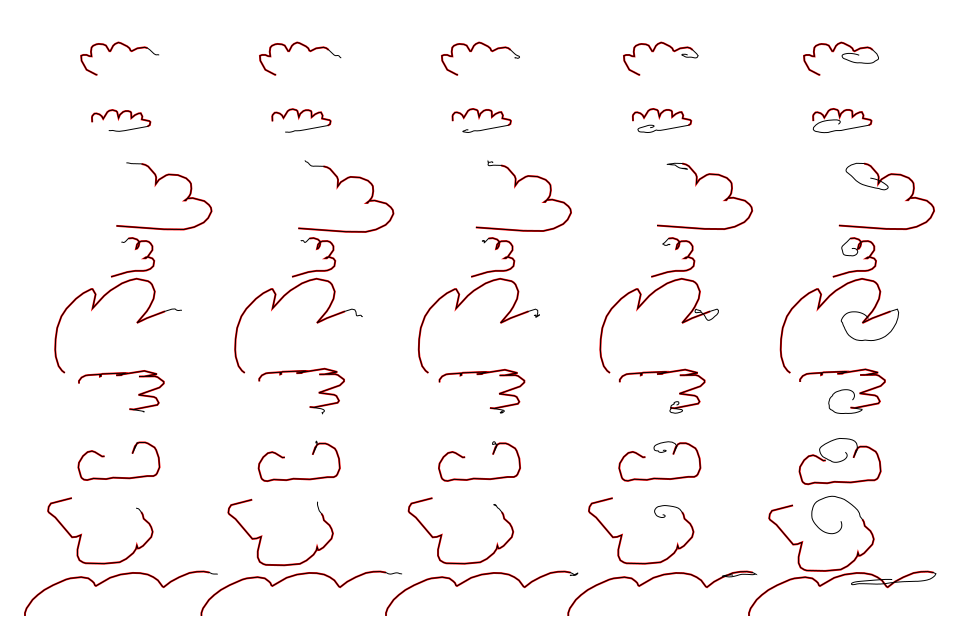

,5,10,15,20,30
1795,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
1055,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
705,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
520,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
219,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
1373,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
739,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
838,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"
229,"[True, False, False, True, 0.36706, 0.26, 0.27]","[True, False, False, True, 0.6597, 0.26, 0.28]","[True, False, False, True, 0.75436, 0.26, 0.28]","[True, False, False, True, 0.78342, 0.25, 0.28]","[True, False, False, True, 0.87383, 0.23, 0.27]"


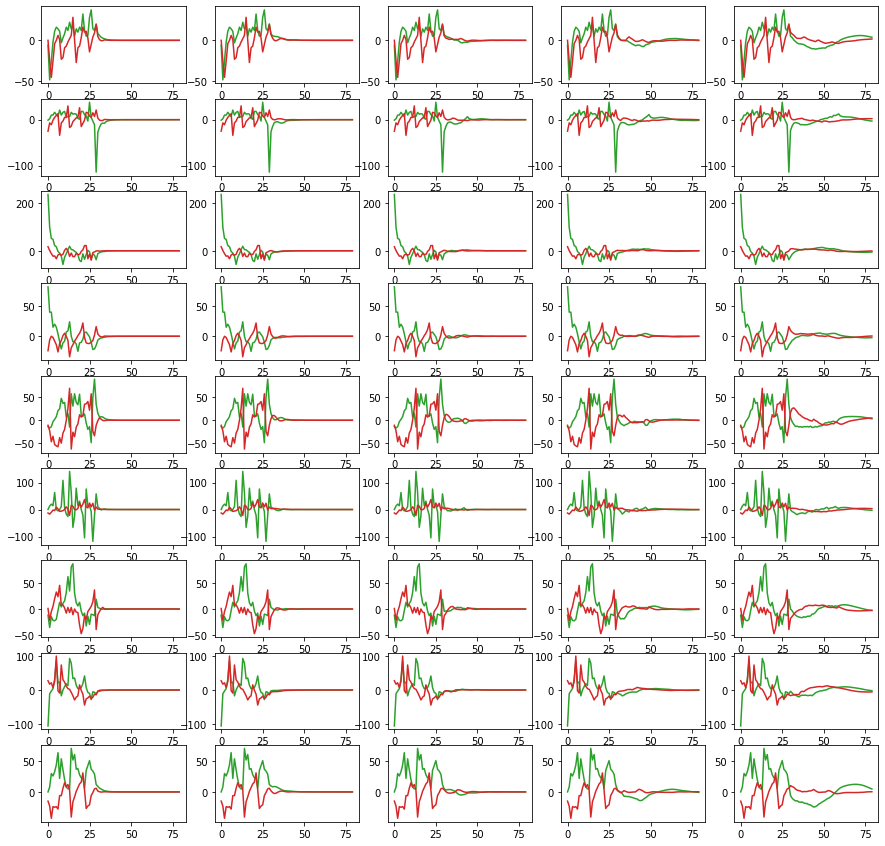

In [95]:
# Choice of the other fixed parameters
### alpha: coeffecient of regression
### s_win: size of the window 
### ini: addition or not of the cumulative distance from the start
### l_inpu: number of data-point take from the test data as input
### lenght: number of data-point to predict

dict_para={"alpha":1,"s_win":30,"ini":False,"l_input":30,"length":50} #Warning l_input needs to be superior to s_win

def test(L_sample,List,dict_para,var_id="alpha"):
    length=dict_para["length"]
    
    L=[]
    A=[[0 for i in range (len(List))]for j in range (len(L_sample))]

    fig, axs = plt.subplots(len(L_sample), len(List),figsize=(15,15))

    for count_ord,var in enumerate(List):
        for count_abs, test_i in enumerate(L_sample):
            
            dict_para[var_id]=var
            alpha,s_win,ini,l_input = dict_para["alpha"],dict_para["s_win"],dict_para["ini"],dict_para["l_input"]
            
            
            draw,w0,w1 = test_model(s_win,ini,alpha,l_input,test_i,length)
            L.append([draw,[count_abs,count_ord]])
            l=matrix_A(s_win,ini,alpha)
            l.append(round(w0,2))
            l.append(round(w1,2))
            A[count_abs][count_ord] = l
            
            # Display the time series
            axs[count_abs, count_ord].plot(draw[:,0],'tab:green',label='Y_target')
            axs[count_abs, count_ord].plot(draw[:,1],'tab:red')
    
    draw_strokes(make_grid_svg(L),factor=5,ini=l_input)
    return pd.DataFrame(A, L_sample, List ) # display information concerning the eigenvalues


test(L_sample,List,dict_para,var_id)

#### Testing the behavior in the limit

{'alpha': 1, 's_win': 30, 'ini': False, 'l_input': 30, 'length': 100} s_win


,5,10,15,20,30
1795,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
1055,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
705,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
520,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
219,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
1373,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
739,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
838,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."
229,"[True, False, False, True, 0.36706, 0.2628, 0....","[True, False, False, True, 0.6597, 0.2585, 0.2...","[True, False, False, True, 0.75436, 0.2589, 0....","[True, False, False, True, 0.78342, 0.2534, 0....","[True, False, False, True, 0.87383, 0.2265, 0...."


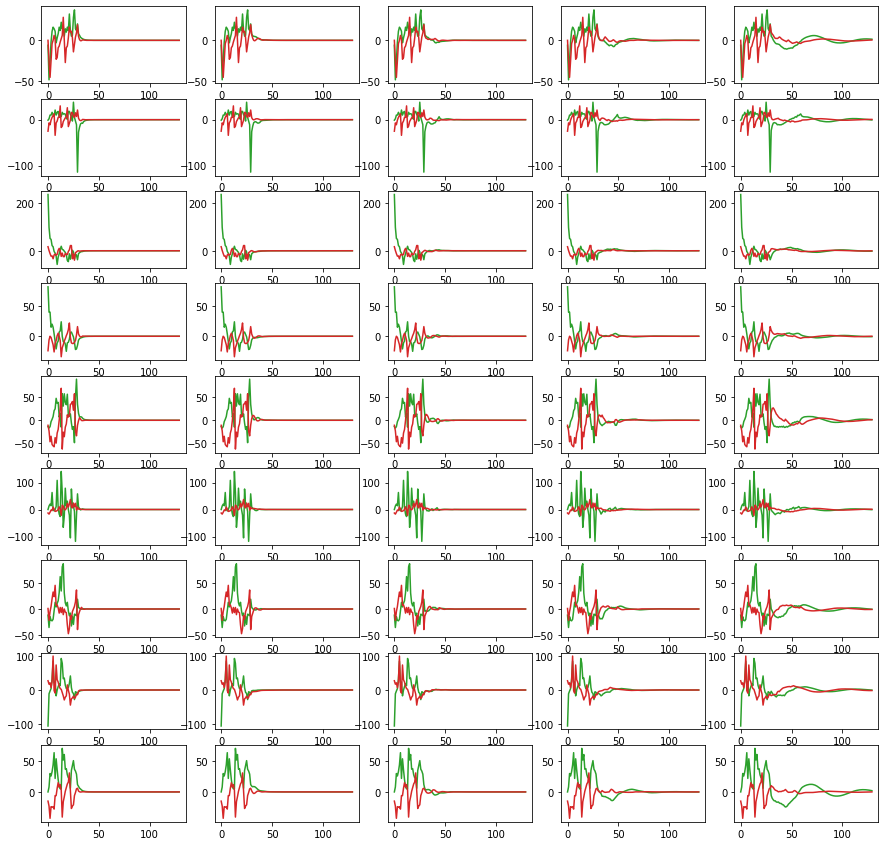

In [93]:
# Test the previous configuration in the limit

dict_para["length"]=100 # Number of points to predict

def test_limit(L_sample,List,dict_para,var_id="alpha"):
    length=dict_para["length"]
    print(dict_para,var_id)
    L=[]
    A=[[0 for i in range (len(List))]for j in range (len(L_sample))]
    
    fig, axs = plt.subplots(len(L_sample), len(List),figsize=(15,15))

    for count_ord,var in enumerate(List):
        for count_abs, test_i in enumerate(L_sample):
            dict_para[var_id]=var
            alpha,s_win,ini,l_input = dict_para["alpha"],dict_para["s_win"],dict_para["ini"],dict_para["l_input"]
            draw,w0,w1 = test_model(s_win,ini,alpha,l_input,test_i,length)
            l=matrix_A(s_win,ini,alpha)
            l.append(round(w0,4))
            l.append(round(w1,4))
            A[count_abs][count_ord] = l
            axs[count_abs, count_ord].plot(draw[:,0],'tab:green')
            axs[count_abs, count_ord].plot(draw[:,1],'tab:red')
    return pd.DataFrame(A, L_sample, List )

test_limit(L_sample,List,dict_para,var_id)